# PPO

In [176]:
import numpy as np
import torch as th
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from torch.distributions import Categorical
from torch import nn
import scipy.stats as st
import itertools
import random
import gym
import torch.nn.init as init

# Environment

In [177]:
class CartPoleEnv:
    def __init__(self, env_name):
        self.env = gym.make(env_name)

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

    def close(self):
        self.env.close()

    def pre_process(self, state, _):
        return th.FloatTensor(state).unsqueeze(0)

# Actor

In [178]:
class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()

        params = Parameters()
        self.gamma = params.gamma
        self.eps_clip = params.eps_clip

        self.layers1_num = params.layers1_num
        self.layers2_num = params.layers2_num
        self.out_num = params.out_num
        self.layers = nn.Sequential(
            nn.Linear(self.layers1_num, self.layers2_num), nn.ReLU(),
            nn.Linear(self.layers2_num, self.out_num),
        )

    def convert_action(self, action):
        return action  # No need to adjust for CartPole

    def forward(self, d_obs, action=None, action_prob=None, advantage=None, deterministic=False):
        if action is None:
            with th.no_grad():
                logits = self.layers(d_obs)
                if deterministic:
                    action = int(th.argmax(logits[0]).detach().cpu().numpy())
                    action_prob = 1.0
                else:
                    c = th.distributions.Categorical(logits=logits)
                    action = int(c.sample().cpu().numpy()[0])
                    action_prob = float(c.probs[0, action].detach().cpu().numpy())
                return action, action_prob

        # PPO
        vs = np.eye(self.out_num)
        ts = th.FloatTensor(vs[action.cpu().numpy()])

        logits = self.layers(d_obs)
        r = th.sum(F.softmax(logits, dim=1) * ts, dim=1) / action_prob
        loss1 = r * advantage
        loss2 = th.clamp(r, 1-self.eps_clip, 1+self.eps_clip) * advantage
        loss = -th.min(loss1, loss2)
        loss = th.mean(loss)

        return loss

# Train Loop

In [179]:
class PPOtrainer:
    def train(self, env, agent, nb_episodes, batch_size):
        tester = Figure()
        params = Parameters()
        opt = th.optim.Adam(agent.parameters(), lr=params.lr)
        reward_sum_running_avg = None
        reward_sum_running_avg_history = []
        training_results = []
        test_results = []

        for it in range(nb_episodes):
            d_obs_history, action_history, action_prob_history, reward_history = [], [], [], []
            episode_rewards = 0

            for ep in range(params.ep):
                obs, prev_obs = env.reset(), None
                for t in range(params.t):
                    d_obs = env.pre_process(obs, prev_obs)

                    with th.no_grad():
                        action, action_prob = agent(d_obs)

                    prev_obs = obs
                    obs, reward, done, _ = env.step(agent.convert_action(action))

                    d_obs_history.append(d_obs)
                    action_history.append(action)
                    action_prob_history.append(action_prob)
                    reward_history.append(reward)

                    episode_rewards += reward

                    if done:
                        reward_sum = sum(reward_history[-t:])
                        reward_sum_running_avg = 0.99 * reward_sum_running_avg + 0.01 * reward_sum if reward_sum_running_avg else reward_sum
                        print(
                            'Iteration %d, Episode %d (%d timesteps) - last_action: %d, last_action_prob: %.2f, reward_sum: %.2f, running_avg: %.2f' % (
                            it, ep, t, action, action_prob, reward_sum, reward_sum_running_avg))
                        reward_sum_running_avg_history.append(reward_sum_running_avg)
                        break

            training_results.append(episode_rewards / params.ep) # Average reward per episode

            # compute advantage
            R = 0
            discounted_rewards = []

            for r in reward_history[::-1]:
                R = r + agent.gamma * R
                discounted_rewards.insert(0, R)

            discounted_rewards = th.FloatTensor(discounted_rewards)
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / discounted_rewards.std()

            # update policy
            for _ in range(params.training_times):
                idxs = random.sample(range(len(action_history)), batch_size)
                d_obs_batch = th.cat([d_obs_history[idx] for idx in idxs], 0)
                action_batch = th.LongTensor([action_history[idx] for idx in idxs])
                action_prob_batch = th.FloatTensor([action_prob_history[idx] for idx in idxs])
                advantage_batch = th.FloatTensor([discounted_rewards[idx] for idx in idxs])

                opt.zero_grad()
                loss = agent(d_obs_batch, action_batch, action_prob_batch, advantage_batch)
                loss.backward()
                opt.step()

            if it % params.test_interval == 0:
                test_reward = tester.test(env, agent)
                test_results.append(test_reward)
                print('Training reward for episode %d: %.2f' % (it, test_reward))

            if it % params.save_episode == 0:
                # th.save(agent.state_dict(), 'params.ckpt')
                pass

        return training_results, test_results

# Test Loop

In [180]:
class Figure:
    def test(self, env, agent):
        obs, prev_obs = env.reset(), None
        reward_sum = 0
        reward_history = []
        params = Parameters()
        for t in range(params.t):
            d_obs = env.pre_process(obs, prev_obs)

            with th.no_grad():
                action, action_prob = agent(d_obs)

            prev_obs = obs
            obs, reward, done, _ = env.step(agent.convert_action(action))

            reward_sum += reward
            reward_history.append(reward)

            if done:
                break

        return reward_sum

# Utilities

In [181]:
class Utils:
    def __init__(self):
        pass

    def benchmark_plot(self, all_train_returns, all_test_returns, test_interval, moving_avg_window=100, down_sample_factor=100):
        num_trials = len(all_train_returns)
        num_points = len(all_test_returns[0])

        # Convert lists to numpy arrays for easier calculations
        all_train_returns = np.array(all_train_returns)
        all_test_returns = np.array(all_test_returns)

        # Calculate the mean and 95% confidence intervals
        mean_train_returns = all_train_returns.mean(axis=0)
        mean_test_returns = all_test_returns.mean(axis=0)

        train_ci = 1.96 * all_train_returns.std(axis=0) / np.sqrt(num_trials)
        test_ci = 1.96 * all_test_returns.std(axis=0) / np.sqrt(num_trials)

        # Calculate individual maximum returns from each trial
        individual_max_returns = [np.max(trial_returns) for trial_returns in all_test_returns]

        # Calculate the average maximum return
        avg_max_return = np.mean(individual_max_returns)

        # Calculate the 95% confidence interval for the average maximum return
        n = len(individual_max_returns)
        sample_std = np.std(individual_max_returns, ddof=1)
        t_value = st.t.ppf(1 - 0.025, df=n - 1)
        margin_of_error = t_value * sample_std / np.sqrt(n)
        avg_max_return_ci = margin_of_error

        # Apply moving average to smooth the training returns
        smoothed_mean_train_returns = np.convolve(mean_train_returns, np.ones(moving_avg_window) / moving_avg_window, mode='valid')
        smoothed_train_ci = np.convolve(train_ci, np.ones(moving_avg_window) / moving_avg_window, mode='valid')

        # Down-sample the training returns for plotting
        down_sampled_indices = np.arange(0, len(smoothed_mean_train_returns), down_sample_factor)
        down_sampled_mean_train_returns = smoothed_mean_train_returns[down_sampled_indices]
        down_sampled_train_ci = smoothed_train_ci[down_sampled_indices]

        # Plot training returns with moving average and confidence interval
        plt.figure(figsize=(12, 6))
        plt.plot(down_sampled_indices, down_sampled_mean_train_returns, label='Mean Training Returns (Smoothed)', color='blue')
        plt.fill_between(down_sampled_indices, down_sampled_mean_train_returns - down_sampled_train_ci, down_sampled_mean_train_returns + down_sampled_train_ci, color='lightblue', alpha=0.3, label='CI')
        plt.xlabel('Episodes')
        plt.ylabel('Training Return')
        plt.title('Training Returns with 95% Confidence Interval (Smoothed)')
        plt.legend()
        plt.show()

        # Plot density plot of training returns
        plt.figure(figsize=(12, 6))
        sns.kdeplot(mean_train_returns, fill=True, label='Density Plot')
        plt.xlabel('Training Return')
        plt.ylabel('Density')
        plt.title('Density Plot of Training Returns')
        plt.legend()
        plt.show()

        # Plot test returns
        plt.figure(figsize=(12, 6))
        episodes = np.arange(0, num_points * test_interval, test_interval)
        for i in range(num_trials):
            plt.plot(episodes, all_test_returns[i], linestyle='dotted', alpha=0.5, label=f'Trial {i+1}')  # Individual test trials
        plt.plot(episodes, mean_test_returns, '-o', label='Mean Test Returns', color='black')  # Mean test returns without error bars
        plt.fill_between(episodes, mean_test_returns - test_ci, mean_test_returns + test_ci, color='lightblue', alpha=0.3, label='CI')  # Fill between upper and lower bounds
        plt.xlabel('Episodes')
        plt.ylabel('Test Return')
        plt.title('Test Returns with 95% Confidence Interval')
        plt.legend()
        plt.show()

        # Plot density plot of test returns
        plt.figure(figsize=(12, 6))
        sns.kdeplot(mean_test_returns, fill=True, label='Density Plot')
        plt.xlabel('Test Return')
        plt.ylabel('Density')
        plt.title('Density Plot of Test Returns')
        plt.legend()
        plt.show()

        return mean_test_returns, avg_max_return, avg_max_return_ci, individual_max_returns


# Main

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Streaming output truncated to the last 5000 lines.
Iteration 504, Episode 9 (388 timesteps) - last_action: 1, last_action_prob: 0.78, reward_sum: 388.00, running_avg: 201.71
Iteration 505, Episode 0 (99 timesteps) - last_action: 0, last_action_prob: 0.81, reward_sum: 99.00, running_avg: 200.68
Iteration 505, Episode 1 (81 timesteps) - last_action: 1, last_action_prob: 0.87, reward_sum: 81.00, running_avg: 199.48
Iteration 505, Episode 2 (75 timesteps) - last_action: 0, last_action_prob: 0.87, reward_sum: 75.00, running_avg: 198.24
Iteration 505, Episode 3 (113 timesteps) - last_action: 1, last_action_prob: 0.84, reward_sum: 113.00, running_avg: 197.39
Iteration 505, Episode 4 (178 timesteps) - last_action: 1, last_action_prob: 0.64, reward_sum: 178.00, running_avg: 197.19
Iteration 505, Episode 5 (273 timesteps) - last_action: 1, last_action_prob: 0.83, reward_sum: 273.00, running_avg: 197.95
Iteration 505, Episode 6 (412 timesteps) - last_action: 0, last_action_prob: 0.58, reward_sum:

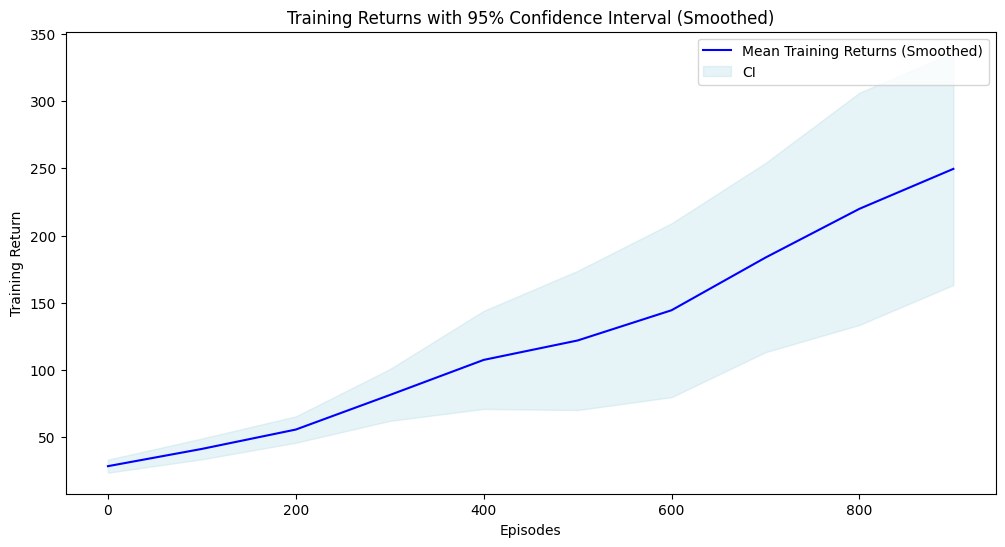

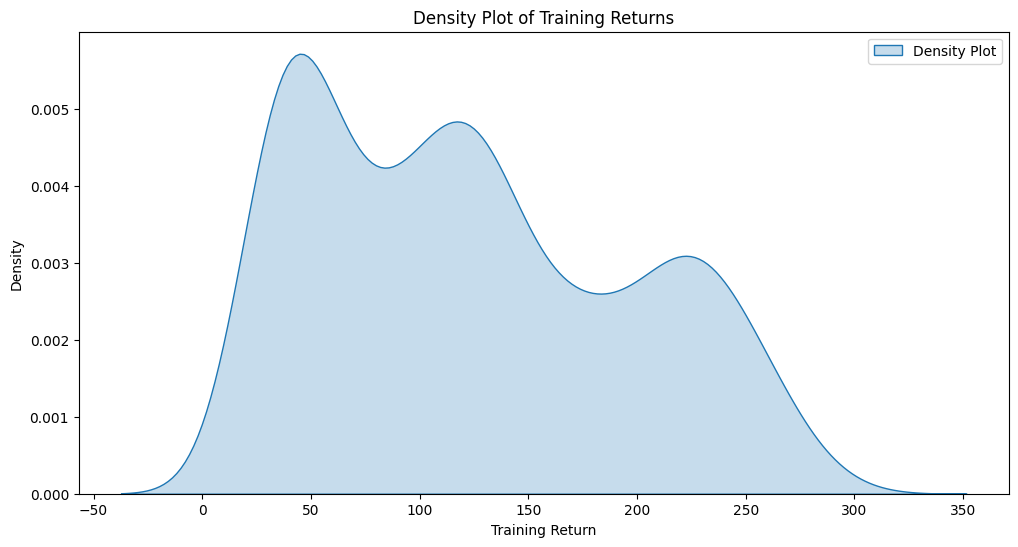

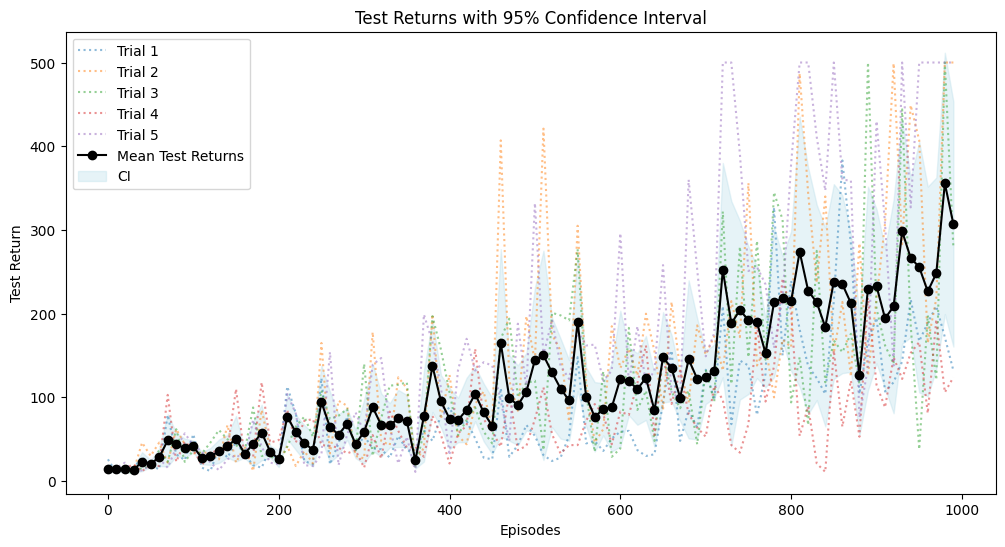

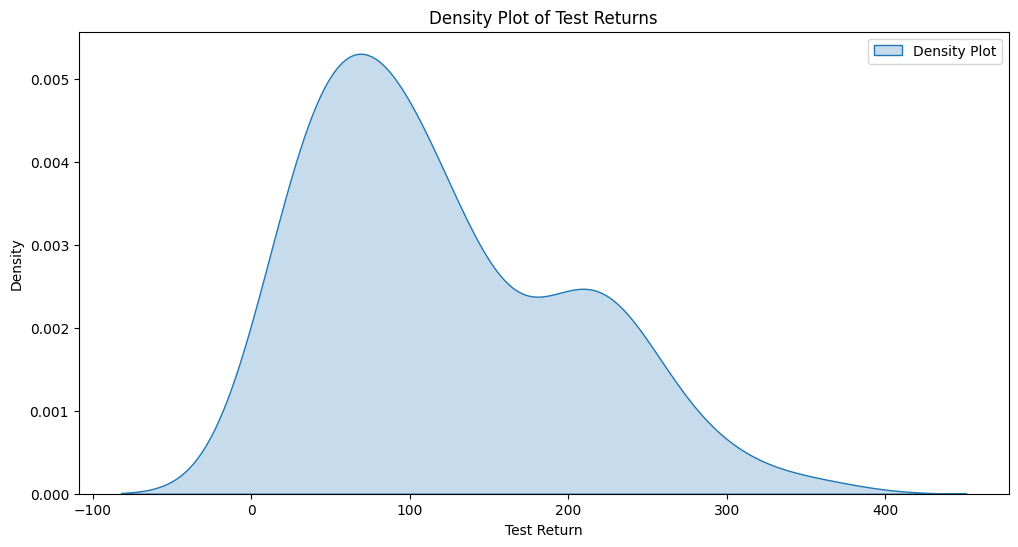

Average Return: [ 15.   14.2  14.   13.4  23.2  20.8  28.4  48.6  43.8  39.2  41.4  27.4
  29.4  35.6  41.6  50.6  32.8  44.2  58.   35.2  26.6  77.   58.2  45.6
  37.2  94.2  64.6  55.6  68.2  44.2  59.   88.2  67.   66.6  74.8  71.8
  24.6  77.6 137.6  95.2  74.6  73.   85.  104.2  82.   65.8 165.   99.4
  90.6 106.8 144.6 150.2 129.8 110.6  96.4 190.4 100.6  76.8  85.8  88.2
 122.4 119.2 110.  123.2  84.4 147.8 135.   99.6 145.4 122.2 123.8 131.2
 252.  188.4 204.2 192.2 189.6 152.8 213.6 218.2 215.  274.  227.2 213.4
 184.  238.4 235.2 212.6 126.6 230.  232.8 194.4 208.6 298.4 266.6 255.6
 226.6 248.2 355.6 307. ]
Max Return: 425.0
Max Return 95% CI: 141.74561242296585
Individual Returns: [383.0, 500.0, 500.0, 242.0, 500.0]
Completed experiment


In [182]:
class Parameters:
    def __init__(self):
        self.nb_episodes = 1000
        self.batch_size = 64
        self.gamma = 0.99
        self.eps_clip = 0.2
        self.layers1_num = 4  # CartPole state space dimension
        self.layers2_num = 128
        self.out_num = 2  # CartPole action space dimension
        self.lr = 3e-4
        self.ep = 10
        self.t = 1000
        self.training_times = 10
        self.save_episode = 50
        self.test_episode = 25
        self.test_interval = 10

def run_experiment(single_config=None):
    num_trials = 5

    env_name = 'CartPole-v1'
    env = CartPoleEnv(env_name)
    env.reset()

    params = Parameters()
    nb_episodes = params.nb_episodes
    batch_size = params.batch_size

    all_train_returns = []
    all_test_returns = []

    for trial in range(num_trials):
        print(f"Trial: {trial+1}")
        agent_ppo = PPO()
        trainer_ppo = PPOtrainer()

        train_rewards, test_rewards = trainer_ppo.train(env, agent_ppo, nb_episodes, batch_size)
        all_train_returns.append(train_rewards)
        all_test_returns.append(test_rewards)

    utils = Utils()
    average_returns, max_return, max_return_ci, individual_returns = utils.benchmark_plot(all_train_returns, all_test_returns, params.test_interval)
    print(f"Average Return: {average_returns}")
    print(f"Max Return: {max_return}")
    print(f"Max Return 95% CI: {max_return_ci}")
    print(f"Individual Returns: {individual_returns}")
    print("Completed experiment")

def main():
    run_experiment()

if __name__ == "__main__":
    main()